In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [26]:
MAIN_IMAGE_PATH = 'image/img2.jpg'
CROP_IMAGE_PATH = 'croped/img2_croped.jpg'

In [27]:
def get_skin_chroma(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    return Cr.astype(np.float32), Cb.astype(np.float32)

In [28]:
def train_skin_model_from_crop(crop_img):
    x, y = get_skin_chroma(crop_img)
    x_flat = x.flatten()
    y_flat = y.flatten()
    
    data = np.vstack((x_flat, y_flat))
    
    mean_vector = np.mean(data, axis=1)
    covariance_matrix = np.cov(data)
    return mean_vector, covariance_matrix

In [29]:
def detect_skin(img, mean, cov):
    x, y = get_skin_chroma(img)
    h, w = x.shape
    
    pixel_data = np.dstack((x, y)).reshape(-1, 2)
    inv_cov = np.linalg.inv(cov)
    diff = pixel_data - mean
    
    dist = np.sqrt(np.sum(np.dot(diff, inv_cov) * diff, axis=1))
    dist_map = dist.reshape(h, w)
    
    mask = dist_map < 3.0
    
    binary_mask = mask.astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return binary_mask

In [30]:
def detect_skin_simple_ratio(img):
    
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    
    # Standard heuristic ranges for skin in YCrCb
    # If a pixel is inside these ranges, we call it skin.
    mask = (Cr >= 133) & (Cr <= 173) & (Cb >= 77) & (Cb <= 127)
    
    return mask.astype(np.uint8) * 255

In [31]:
def check_sensitivity(img, mean, cov):
    
    # reduce brightness by 50
    darker = cv2.convertScaleAbs(img, alpha=1, beta=-50)
    
    # increase brightness by 50
    lighter = cv2.convertScaleAbs(img, alpha=1, beta=50)
    
    mask_dark = detect_skin(darker, mean, cov)
    mask_light = detect_skin(lighter, mean, cov)
    
    return darker, mask_dark, lighter, mask_light

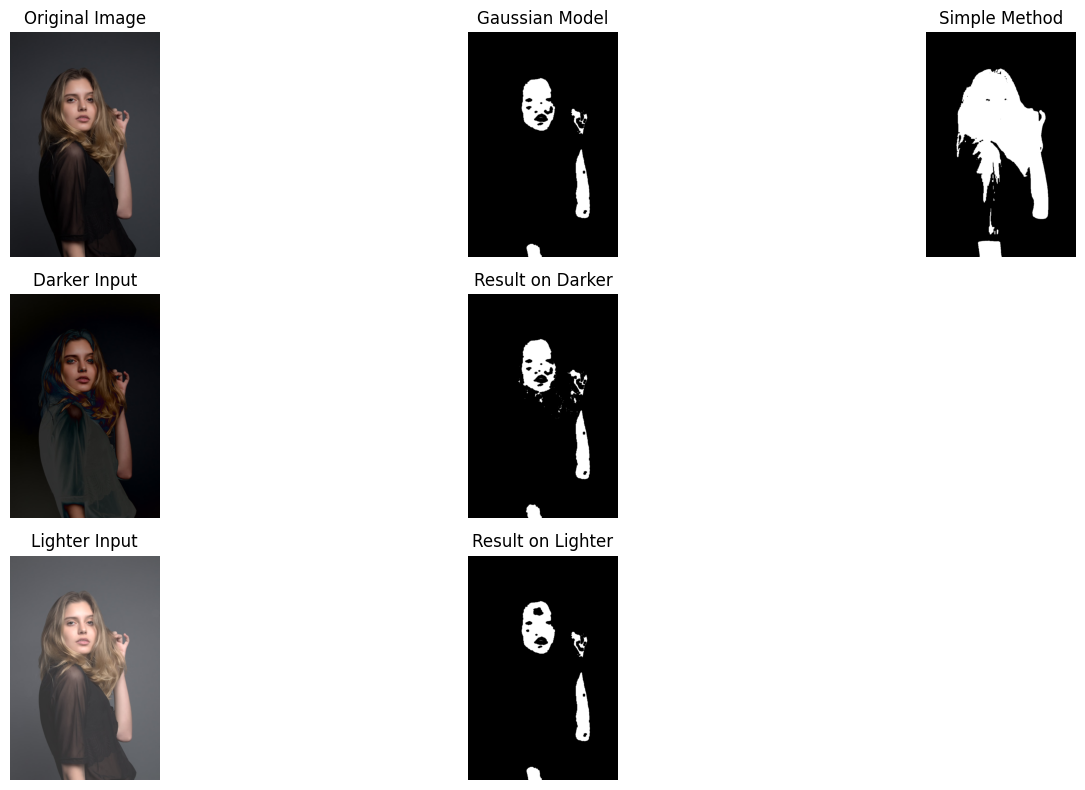

Calculated Mean Vector:
 [151.06572 113.00726]
Calculated Covariance Matrix:
 [[ 9.15623286 -8.0994395 ]
 [-8.0994395   7.72416867]]


In [32]:
main_img = cv2.imread(MAIN_IMAGE_PATH)
skin_crop = cv2.imread(CROP_IMAGE_PATH)

if main_img is None or skin_crop is None:
    print("Error loading images. Please check your paths.")
else:
    
    mean, cov = train_skin_model_from_crop(skin_crop)
    mask_gaussian = detect_skin(main_img, mean, cov)
    
    # simple method
    mask_simple = detect_skin_simple_ratio(main_img)
    
    
    img_dark, mask_dark, img_light, mask_light = check_sensitivity(main_img, mean, cov)

    
    
    # 1. Compare Gaussian vs Simple (Step 4 vs Step 6)
    plt.figure(figsize=(15, 8))
    
    # Original Image
    plt.subplot(3, 3, 1)
    plt.imshow(cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    
    plt.subplot(3, 3, 2)
    plt.imshow(mask_gaussian, cmap='gray')
    plt.title("Gaussian Model")
    plt.axis('off')
    
    
    plt.subplot(3, 3, 3)
    plt.imshow(mask_simple, cmap='gray')
    plt.title("Simple Method")
    plt.axis('off')

    
    plt.subplot(3, 3, 4)
    plt.imshow(cv2.cvtColor(img_dark, cv2.COLOR_BGR2RGB))
    plt.title("Darker Input")
    plt.axis('off')

   
    plt.subplot(3, 3, 5)
    plt.imshow(mask_dark, cmap='gray')
    plt.title("Result on Darker")
    plt.axis('off')
    
    
    plt.subplot(3, 3, 7)
    plt.imshow(cv2.cvtColor(img_light, cv2.COLOR_BGR2RGB))
    plt.title("Lighter Input")
    plt.axis('off')
    
    plt.subplot(3, 3, 8)
    plt.imshow(mask_light, cmap='gray')
    plt.title("Result on Lighter")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    
    print(f"Calculated Mean Vector:\n {mean}")
    print(f"Calculated Covariance Matrix:\n {cov}")